Alejandro Mariacca Santin
A01654102

In [582]:
%matplotlib inline
import matplotlib.pyplot as ptl

In [583]:
def compute_gini(model):
    agent_points = [agent.puntos for agent in model.schedule.agents]
    x = sorted(agent_points)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

In [584]:
import mesa
class AspiradoraAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.puntos = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def clean(self):
        cell = self.model.grid.get_cell_list_contents([self.pos])
        # print(cell)
        for element in cell:
            if isinstance(element, TrashAgent) == True:
                self.model.grid.remove_agent(element)
                self.puntos += 1

    def step(self):
        self.move()
        self.clean()


class AspiradoraModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, Basura, width, height):
        self.num_agents = N
        self.basura = Basura

        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.schedule2 = mesa.time.RandomActivation(self)
        self.running = True
        
        for i in range(self.num_agents):
            a = AspiradoraAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (1, 1))

        for i in range(self.basura):
            a = TrashAgent(i + self.num_agents, Basura)
            self.schedule2.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))



        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Puntos": "puntos"}
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    

class TrashAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)


(array([  0.,   8.,  38.,  75., 109.,  98.,  74.,  43.,  30.,  14.,  11.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 11 artists>)

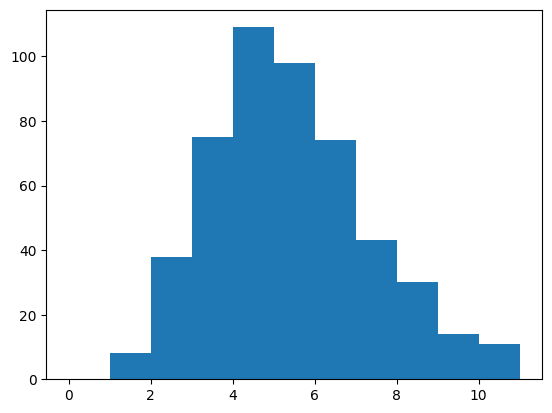

In [585]:
all_wealth = []

# This runs the model 100 times, each model executing 100 steps.
for j in range(100):
    # Run the model
    model = AspiradoraModel(5, 20, 10, 10)
    for i in range(100):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.puntos)

ptl.hist(all_wealth, bins=range(max(all_wealth) + 1))


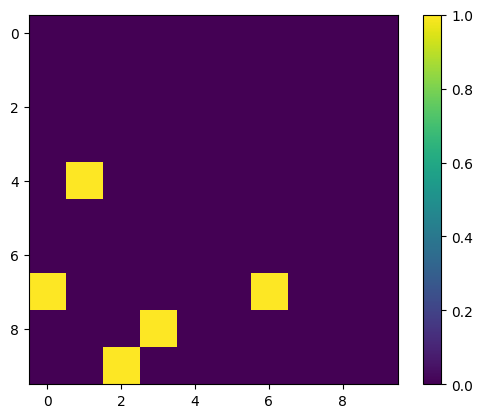

In [586]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
ptl.imshow(agent_counts, interpolation="nearest")
ptl.colorbar()

<AxesSubplot: >

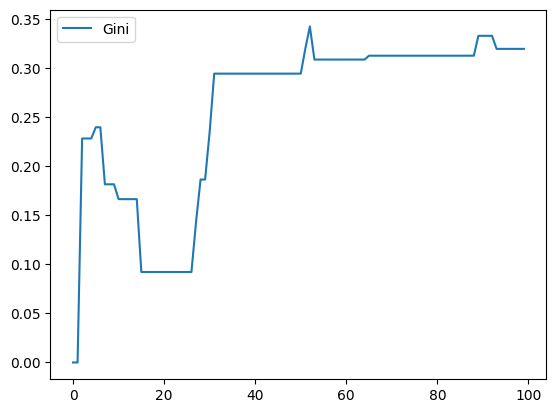

In [587]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [588]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Puntos
Step AgentID        
99   0             4
     1             3
     2             5
     3            11
     4             2

In [589]:
params = {"width": 10,  "height": 10, "N": 5,"Basura": 20}
#params = {"width": 10,  "height": 10, "N": range(1, 110, 10),"Basura": 20}
results = mesa.batch_run(
    AspiradoraModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 55/55 [00:01<00:00, 49.36it/s]


In [590]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Basura', 'Gini',
       'AgentID', 'Puntos'],
      dtype='object')


<AxesSubplot: xlabel='AgentID'>

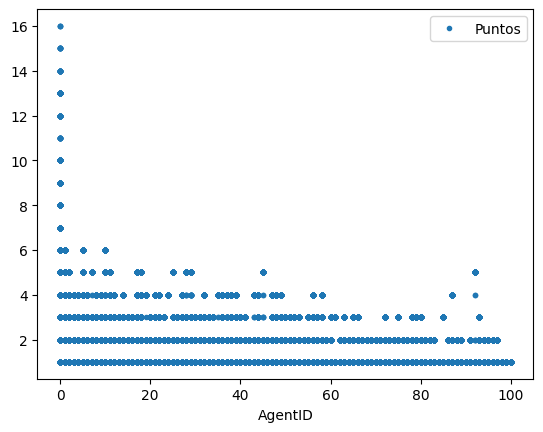

In [591]:
results_df.plot(x='AgentID', y='Puntos', style='.')


<AxesSubplot: xlabel='Step'>

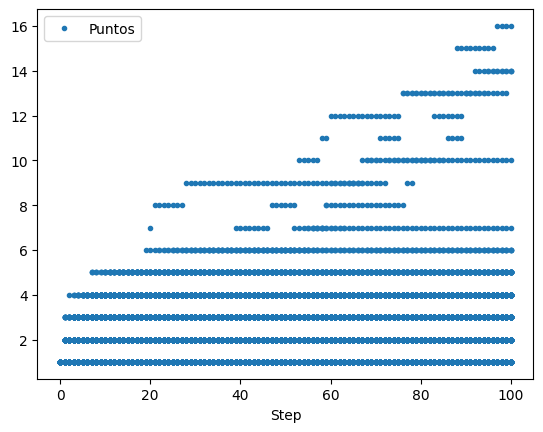

In [592]:
results_df.plot(x='Step', y='Puntos', style='.')

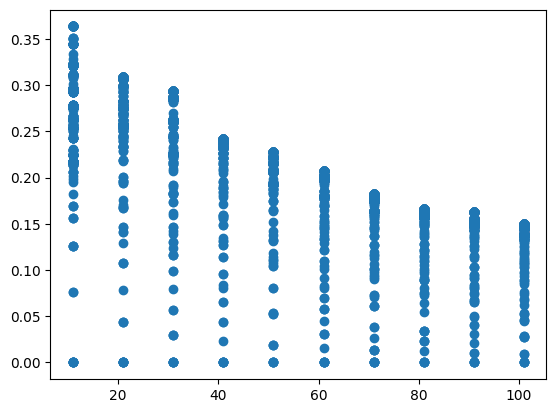

In [593]:
results_filtered = results_df[(results_df.AgentID == 2) & (results_df.Step <= 101)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
ptl.scatter(N_values, gini_values)

Estas son funciones que representan datos de forma numérica y no en forma de tabla.

In [594]:
# First, we filter the results
one_episode_wealth = results_df#[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Puntos"], max_rows=25
    )
)

 Step  AgentID  Puntos
    0        0       1
    1        0       1
    2        0       1
    3        0       2
    4        0       2
    5        0       2
    6        0       2
    7        0       2
    8        0       2
    9        0       2
   10        0       3
   11        0       3
  ...      ...     ...
  100       89       1
  100       90       1
  100       91       1
  100       92       1
  100       93       1
  100       94       1
  100       95       1
  100       96       2
  100       97       2
  100       98       1
  100       99       1
  100      100       1


In [595]:
results_one_episode = results_df

print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step    Gini
    0 0.00000
    1 0.00000
    2 0.00000
    3 0.00000
    4 0.00000
    5 0.00000
    6 0.00000
    7 0.00000
    8 0.00000
    9 0.00000
   10 0.00000
   11 0.00000
  ...     ...
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
  100 0.13845
